In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import datetime
from DnCNN import DnCNN
from compute_gradient import CNN_LOSS
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from keras import backend as K

from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[]

In [5]:
# operations

def plot_color_evf(evf):
    dim1 = np.size(evf, 0)
    dim2 = np.size(evf, 1)
    neg_c = np.array([212, 20, 90])/255.
    pos_c = np.array([63, 169, 245])/255.
    canvas = np.ones((dim1, dim2, 3))*0.5
    for i in range(dim1):
        for j in range(dim2):
            if evf[i,j] == 1:
                canvas[i,j,:] = pos_c
            elif evf[i,j] == -1:
                canvas[i,j,:] = neg_c
    return canvas

def vid2evf(vid, event_thres = 0.08):
    dim0, dim1, dim2 = np.shape(vid)
    lvid = np.log(vid+1e-10)
    evf = np.zeros((dim0-1, dim1, dim2))
    for i in range(dim0 - 1):
        frame_diff = lvid[i+1,:,:] - lvid[i,:,:]
        ievf = np.zeros_like(frame_diff,dtype=np.float)
        ievf[frame_diff>event_thres] = 1.0
        ievf[frame_diff<-event_thres] = -1.0
        if i == 0:
            evf = ievf
        else:
            evf = np.dstack((evf, ievf))
    return evf

def norm_per_frame(vid):
    return np.array([norm_max(vid[i,:,:]) for i in range(np.size(vid,0))])

def norm_max(x):
    return x/np.amax(x)

def hres_predict(config, hres, model):
    for iframe in range(np.size(hres,3)):
        if iframe == 0:
            hpred = model.predict(np.expand_dims(hres[:,:,:,iframe], 3))
        else:
            hpred = np.concatenate((hpred, model.predict(np.expand_dims(hres[:,:,:,iframe], 3))), 3)
    return hpred

def hres_pnp(config, hres, model):
    for iframe in range(np.size(hres,3)):
        if iframe == 0:
            hpred = model.predict(np.expand_dims(hres[:,:,:,iframe], 3))
        else:
            hpred = np.concatenate((hpred, model.predict(np.expand_dims(hres[:,:,:,iframe], 3))), 3)
    #hpred = config.res_coef*hpred + (1-config.res_coef)*hres
    return tf.convert_to_tensor(hpred, dtype = 'float32')

In [6]:
# models
def init_hres(config, lres_gt):
    lres_gt_var = tf.Variable(lres_gt)
    # init hres
    if config.hres_init_type == 0:
        hres_partial = tf.Variable(tf.random_uniform(config.evf_dim))
        if config.lres_type == 0:
            print("hres initialized, frame 0 == reference")
            return tf.concat([lres_gt_var, hres_partial], 3)
        elif config.lres_type == 1:
            print("hres initialized, frame 1 == reference")
            return tf.concat([hres_partial, lres_gt_var], 3)
    elif config.hres_init_type == 1:
        for i in range(config.ev_dim):
            lres_gt_var = tf.concat([lres_gt_var, tf.Variable(lres_gt)], 3)
        print("hres initialized, ", np.shape(lres_gt_var))
        return lres_gt_var
    
def init_flow(config):
    if config.flow_init == 0:
        flow_x = tf.Variable(tf.zeros(config.hres_dim))
        flow_y = tf.Variable(tf.zeros(config.hres_dim))
        flow = tf.concat([flow_x, flow_y], 0)
        return flow
        
def frame_model(config, hres_tensor):
    hres_transpose = tf.transpose(hres_tensor, perm = [3,0,1,2])
    if config.lres_type == 0:
        lres_transpose = tf.gather_nd(hres_transpose, indices = [[0]])
    elif config.lres_type == 1:
        lres_transpose = tf.gather_nd(hres_transpose, indices = [[0]])
    return tf.transpose(lres_transpose, perm = [1,2,3,0])

def event_model(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    tanh_coef = tf.constant(config.tanh_coef)
    #kernel = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 1), dim = 0), dim = 0)
    #print(np.shape(hres_tensor))
    #print(np.shape(kernel))
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 0), dim = 3), dim = 4)
    tf_evf = tf.tanh(tanh_coef*tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "VALID", data_format = "NDHWC"))
    return tf.squeeze(tf_evf, [4])

def tv_2d(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 1), dim = 2), dim = 3), dim = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 2), dim = 3), dim = 4)

    dx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    return tf.norm(dx+dy, ord = 1)

def tv_t(config, hres_tensor):
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.constant([-1,1], dtype = tf.float32), dim = 0), dim = 0), dim = 3), dim = 4)
    dt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    return tf.norm(dt, ord = 1)

def flow_loss(config, hres_tensor, flow):
    flowx_tensor = tf.slice(flow, [0,0,0,0],[1,-1,-1,-1])
    flowy_tensor = tf.slice(flow, [1,0,0,0],[1,-1,-1,-1])
    hres_ndhwc = tf.expand_dims(hres_tensor, dim = 4)
    flowx_ndhwc = tf.expand_dims(flowx_tensor, dim = 4)
    flowy_ndhwc = tf.expand_dims(flowy_tensor, dim = 4)
    
    flow_coef_xy = tf.constant(config.flow_norm_xy_coef, dtype = tf.float32)
    flow_coef_t = tf.constant(config.flow_norm_t_coef, dtype = tf.float32)
    kernel = tf.constant([-1,1], dtype = tf.float32)
    
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 1), dim = 2), dim = 3), dim = 4)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 0), dim = 2), dim = 3), dim = 4)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, dim = 0), dim = 0), dim = 3), dim = 4)
    
    dHx = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dHy = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dHt = tf.squeeze(tf.nn.convolution(input = hres_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    flow_eq = tf.multiply(dHx, flowx_tensor) + tf.multiply(dHy, flowy_tensor) + dHt
    
    dUxx = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUxy = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUyx = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kx, padding = "SAME", data_format = "NDHWC"), [4])
    dUyy = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = ky, padding = "SAME", data_format = "NDHWC"), [4])
    dUxt = tf.squeeze(tf.nn.convolution(input = flowx_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    dUyt = tf.squeeze(tf.nn.convolution(input = flowy_ndhwc, filter = kt, padding = "SAME", data_format = "NDHWC"), [4])
    
    return tf.norm(flow_eq, ord = 1) + flow_coef_xy*tf.norm(dUxx+dUxy+dUyx+dUyy, ord = 1)+ flow_coef_t*tf.norm(dUxt+dUyt, ord = 1)


def loss_all(config, ph, hres_tensor, lres_tensor, evf_tensor, flow_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    opt_flow_loss = tf.constant(config.flow_loss_coef)*flow_loss(config, hres_tensor, flow_tensor)
    return frame_loss + event_loss + tv_loss + opt_flow_loss

def loss_no_flow(config, ph, hres_tensor, lres_tensor, evf_tensor):
    # frame_loss = tf.reduce_mean(tf.squared_difference(ph.lres_gt, lres_tensor))
    # event_loss = tf.constant(config.ev_weight)*tf.reduce_mean(tf.squared_difference(ph.evf_gt, evf_tensor))
    frame_loss = tf.norm(ph.lres_gt - lres_tensor, ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - evf_tensor, ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

(20, 300, 300)


<IPython.core.display.Javascript object>


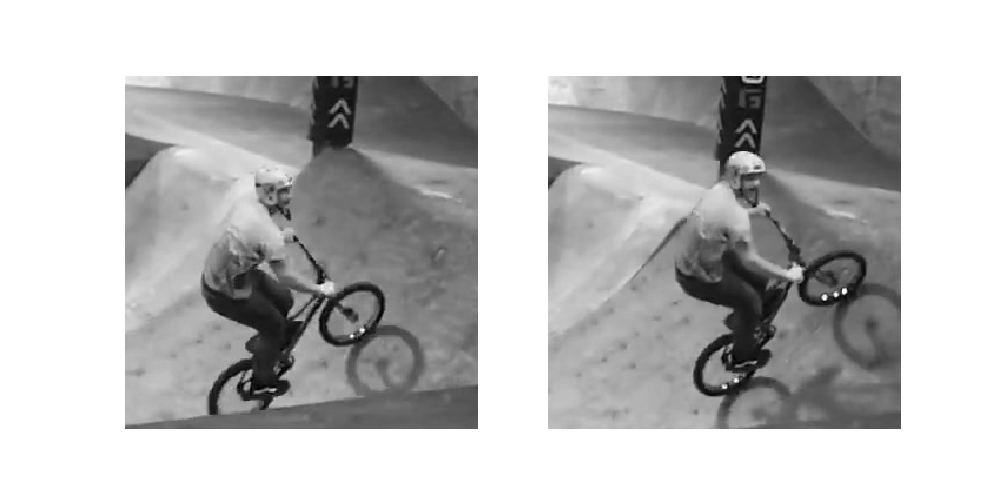

In [15]:
# load data
data_dir = 'need4speed/'
filename = 'clip_20f_biker_head_2.npy'
vid = np.load(data_dir + filename)
vid_norm = norm_per_frame(vid)
print(np.shape(vid_norm))
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(vid[0,:,:], cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(vid[19,:,:], cmap = 'gray')
plt.axis('off')
plt.show()

In [28]:
num_frames = np.size(vid,0)
threshold = 0.3
evf_vid = vid2evf(vid, threshold)
print(np.shape(evf_vid))


(300, 300, 19)


<IPython.core.display.Javascript object>


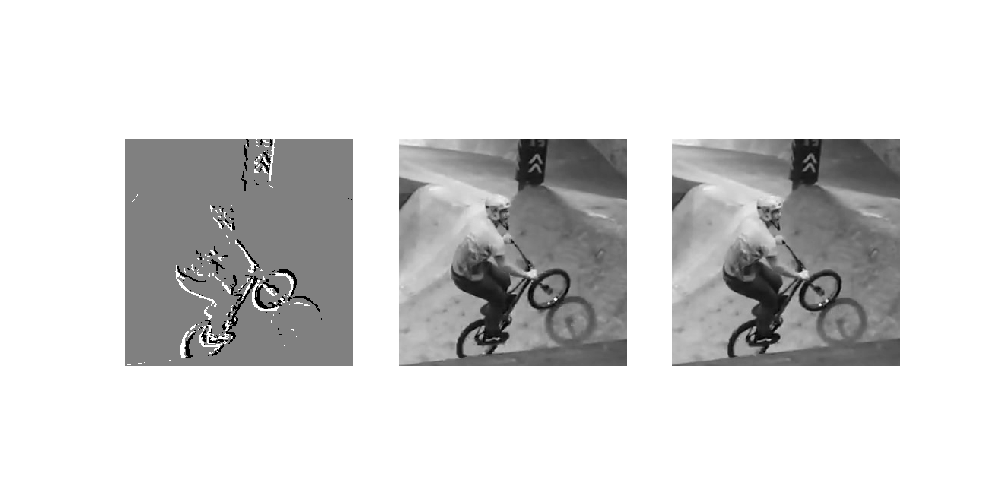

In [29]:
plt.figure(figsize = (10,5))
iframe = 1
plt.subplot(131)
plt.imshow(evf_vid[:,:,iframe], cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(vid[iframe+1,:,:], cmap = 'gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(vid[iframe,:,:], cmap = 'gray')
plt.axis('off')
plt.show()

In [37]:
num_evf = 5
hres_gt = np.expand_dims(np.transpose(np.array([vid[0,:,:], vid[num_evf,:,:]]), (1,2,0)), 0)
lres_gt = np.expand_dims(np.expand_dims(vid[0,:,:], 2), 0)
evf_gt = np.expand_dims(evf_vid[:,:,0:num_evf], 0)
print("shape of hres_gt", np.shape(hres_gt))
print("shape of lres_gt", np.shape(lres_gt))
print("shape of evf_gt", np.shape(evf_gt))
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_gt), np.amin(hres_gt)))

shape of hres_gt (1, 300, 300, 2)
shape of lres_gt (1, 300, 300, 1)
shape of evf_gt (1, 300, 300, 5)
Max value 0.99, min value 0.00


In [38]:
res_model = DnCNN(depth=17,filters=64,image_shape=[np.size(hres_gt,1),np.size(hres_gt,2),1],use_bnorm=True)

In [39]:
# config
class config():
    def __init__(self, dim = None, ev_dim = 1):
        if dim == None:
            self.dim1 = 180
            self.dim2 = 240
        else:
            self.dim1, self.dim2 = dim
        self.ev_dim = ev_dim
        self.hres_dim = (1, self.dim1, self.dim2, self.ev_dim + 1)
        self.lres_dim = (1, self.dim1, self.dim2, 1)
        self.evf_dim = (1, self.dim1, self.dim2, self.ev_dim)
        # frames
        self.hres_init_type = 1 # 0: initialize from random 1: initialize from lr video
        self.lres_type = 0  # 0: start frame; 1: end frame
        
        # events
        self.ev_weight = 1e-1
        self.tanh_coef = 10.0
        
        # hres_tv
        self.tv_coef_xy = 3e-1
        self.tv_coef_t = 1e-2

        # learning
        self.lr = 0.008
        self.lr_decay = 0.9
        self.epochs = 71
        self.beta1 = 0.9
        self.beta2 = 0.99

def lr_schedule(config, epoch):
    fac = 0.96
    if epoch % 100 == 0:
        config.lr = config.lr*fac
    return config
# place holder
class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)

In [40]:
dim = (np.size(hres_gt,1),np.size(hres_gt, 2))
res_config = config(dim, np.size(evf_gt, 3))
res_ph = place_holder(res_config)

hres_tensor = init_hres(res_config, lres_gt)
lres_tensor = frame_model(res_config, hres_tensor)
evf_tensor = event_model(res_config, hres_tensor)
loss = loss_no_flow(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)

optimizer = tf.train.AdamOptimizer(learning_rate = res_ph.learning_rate, beta1 = res_config.beta1, beta2 = res_config.beta2)
opt_min = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

iloss = np.empty((res_config.epochs,))
for iepoch in range(res_config.epochs):
    hres_rec, iloss[iepoch], _ = sess.run([hres_tensor, loss, opt_min],
                               feed_dict={res_ph.lres_gt: lres_gt, 
                                          res_ph.evf_gt: evf_gt, 
                                          res_ph.learning_rate: res_config.lr})
    if iepoch % 10 == 0:
        res_config.lr = res_config.lr*0.95
        
        hres_gt1 = np.squeeze(hres_gt[:,:,:,-1])
        hres1 = np.squeeze(hres_rec[:,:,:,-1])
        hres1_ssim = ssim(hres_gt1,hres1)
        hres1_psnr = psnr(hres_gt1,hres1)
        print("Epoch---->", iepoch, "  loss---->", iloss[iepoch], "  SSIM---->", hres1_ssim, "  PSNR---->", hres1_psnr)
    #if iepoch % 3 == 0:
    #    hres_tensor = hres_pnp(res_config, hres_rec, res_model)
        
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_rec), np.amin(hres_rec)))

hres initialized,  (1, 300, 300, 6)


/home/winston/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


Epoch----> 0   loss----> 7029.2294921875   SSIM----> 0.6674796262329774   PSNR----> 17.421409019214366
Epoch----> 10   loss----> 6873.548828125   SSIM----> 0.7016323986379027   PSNR----> 17.971380598249638
Epoch----> 20   loss----> 5996.9140625   SSIM----> 0.7186225809366436   PSNR----> 18.41897563720549
Epoch----> 30   loss----> 5525.8017578125   SSIM----> 0.7289059537306456   PSNR----> 18.770331171804774
Epoch----> 40   loss----> 5268.21923828125   SSIM----> 0.7353168169099369   PSNR----> 19.046589241491247
Epoch----> 50   loss----> 5094.357421875   SSIM----> 0.7401559639588157   PSNR----> 19.275350647745814
Epoch----> 60   loss----> 4984.75146484375   SSIM----> 0.7442869433359008   PSNR----> 19.470866497438013
Epoch----> 70   loss----> 4889.40673828125   SSIM----> 0.747762795519413   PSNR----> 19.635677529798127
Max value 0.99, min value -0.16


<IPython.core.display.Javascript object>


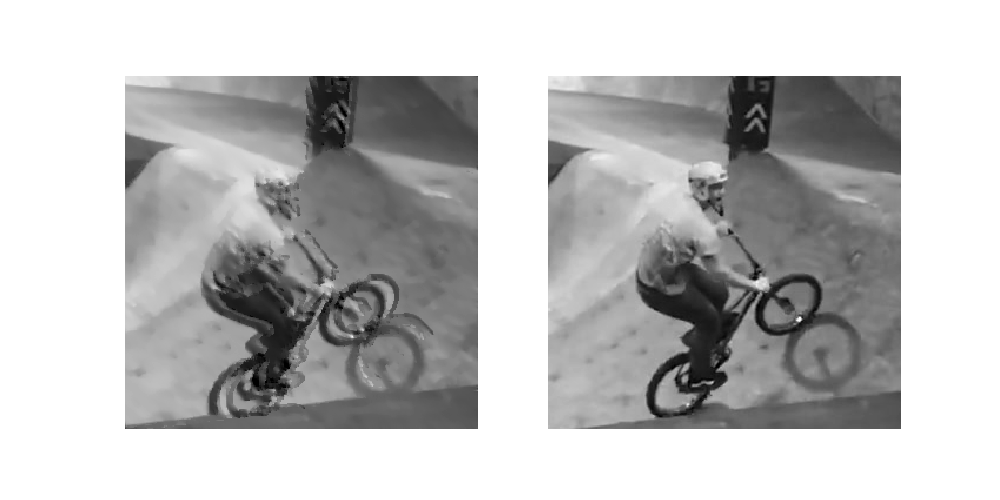

Error max 0.6097792
Error min -0.64371014


In [41]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(np.squeeze(hres_rec[:,:,:,-1]),cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.show()
plt.subplot(122)
plt.imshow(np.squeeze(hres_gt[:,:,:,-1]), cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.show()
#
err_max = np.amax(hres_rec[:,:,:,-1]-hres_gt[:,:,:,-1])
err_min = np.amin(hres_rec[:,:,:,-1]-hres_gt[:,:,:,-1])
print("Error max", err_max)
print("Error min", err_min)



In [42]:
hres_dn = hres_predict(res_config, hres_rec, res_model)
dn_psnr = psnr(hres_gt[:,:,:,-1], hres_dn[:,:,:,-1])
dn_ssim = ssim(np.squeeze(hres_gt[:,:,:,-1]), np.squeeze(hres_dn[:,:,:,-1]))
print("SSIM:", dn_ssim, "PSNR:", dn_psnr)

SSIM: 0.7477902400017667 PSNR: 19.636786576183457


/home/winston/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


<IPython.core.display.Javascript object>


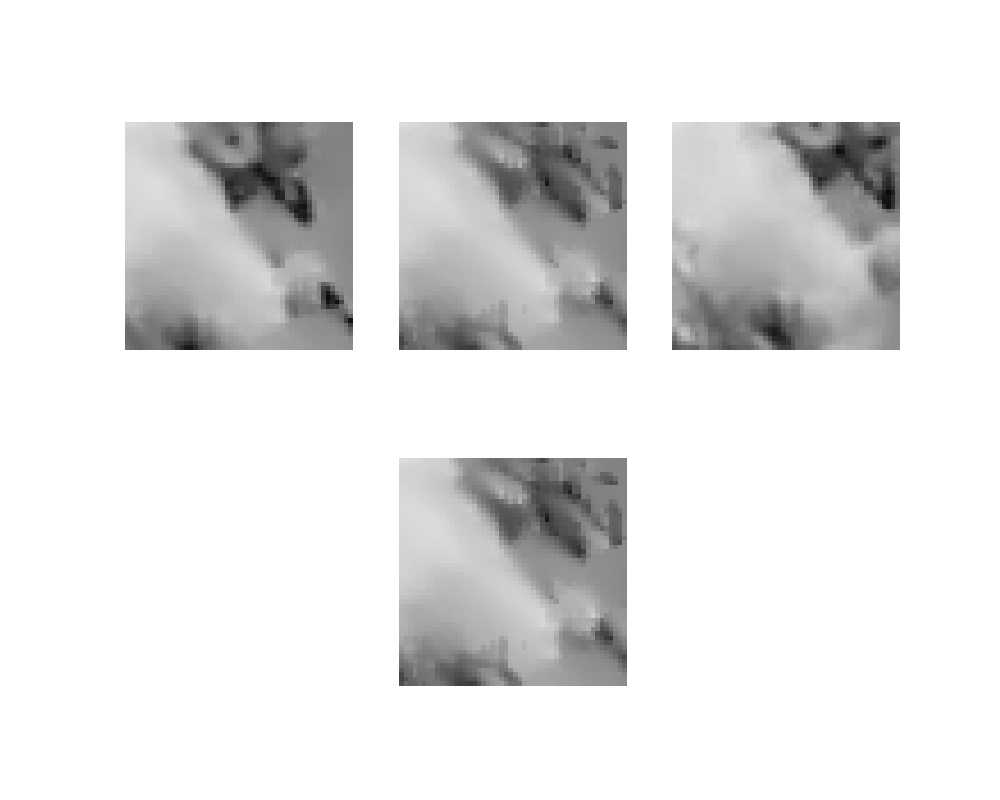

(-0.5, 49.5, 49.5, -0.5)

In [43]:
sidx1 = 100
sidx2 = 100
dim = 50

plt.figure(figsize = (10,8))
plt.subplot(231)
plt.imshow(np.squeeze(hres_rec[:,sidx1:(sidx1+dim),sidx2:(sidx2+dim),0]),cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.subplot(232)
plt.imshow(np.squeeze(hres_rec[:,sidx1:(sidx1+dim),sidx2:(sidx2+dim),-1]),cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.subplot(233)
plt.imshow(np.squeeze(hres_gt[:,sidx1:(sidx1+dim),sidx2:(sidx2+dim),-1]), cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.show()
plt.subplot(235)
plt.imshow(np.squeeze(hres_dn[:,sidx1:(sidx1+dim),sidx2:(sidx2+dim),-1]),cmap='gray')
plt.clim(0,1)
plt.axis('off')

<IPython.core.display.Javascript object>


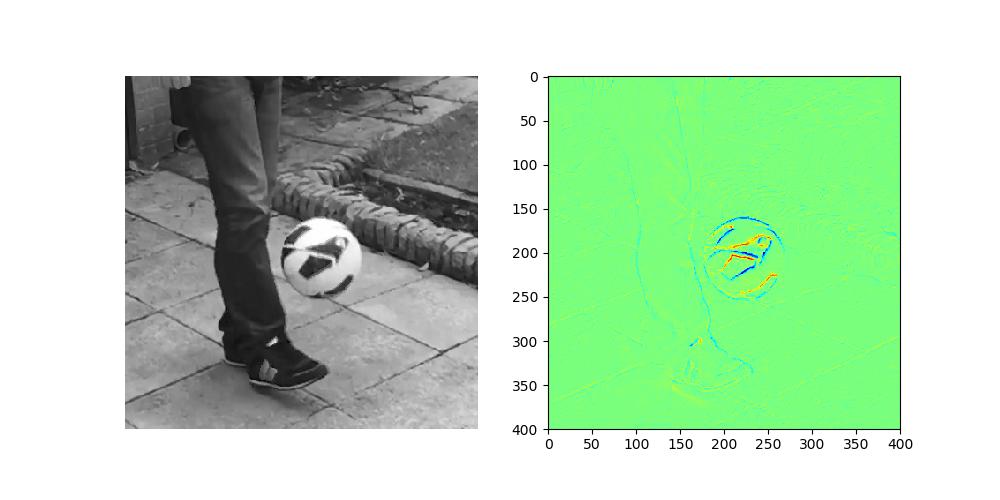

In [317]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(np.squeeze(hres_dn[:,:,:,-1]),cmap='gray')
plt.clim(0,1)
plt.axis('off')
plt.show()
plt.subplot(122)
plt.imshow(np.squeeze(hres_dn[:,:,:,-1]-hres_gt[:,:,:,-1]), cmap='jet')
plt.clim(-0.5,0.5)
#plt.axis('off')
plt.show()

In [10]:
res_model = DnCNN(depth=17,filters=64,image_shape=[180,240,1],use_bnorm=True)

In [18]:
test_img = np.empty((1,180,240,1))
t0 = time.time()
img_out = res_model.predict(test_img)
print(time.time()-t0)

0.40329480171203613
